<a href="https://colab.research.google.com/github/shimjaeman/PyTorch-Tutorials/blob/main/05_(Pytorch)_Recurrent_Neural_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence(시퀀스) 이론 설명


1. Sequence(시퀀스) : 순서가 있는 data

   - Text (문맥), 시계열 (시간), 영상, 음성 등의 순서가 있는 데이터



2. Sequence Model(시퀀스 모델) : Sequence data를 다루는 모델

  - 순차적으로 과거 정보를 반영할 수 있는 모델

3. Sequence model 종류

  1. one to many

    - Image Captioning : image -> sequence of words

    - language model

  2. many to one

    - Sentiment Classification : sequence of words -> sentiment

    - Time series analysis

  3. many to many (encoder -> decoder)

    - Machine Translation : sequence of words -> sequence of words

    - Transformer 

  4. many to many

    - Name entity recognition 

    - Video classification on frame level

​

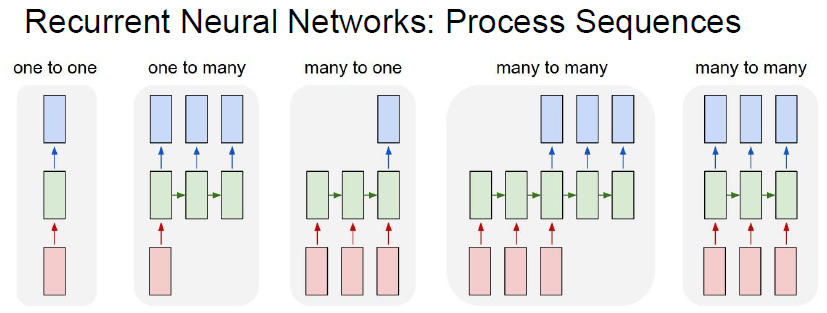

# Recurrent Neural Network


## RNN 개념

1. RNN 개념

   * RNN :  Recurrent Neural Network의 줄임말로, 음성이나 문자처럼 순차적으로 나타나는 Sequence data에 적합한 모델

   * 시퀀스 길이에 관계없이 인풋과 아웃풋을 받아들일 수 있는 네트워크 구조이기 때문에 필요에 따라 다양하고 유연한 구조 가능

   * 입력 또는 출력 데이터가 sequence로 주어진 상황에서 각 time step에서 들어오는 입력 벡터 x와 그 전 time step의 RNN 모듈에서 계산한 hidden state인 h(t-1)을 입력으로 받아서 현재 time step에서의 hidden state인 h(t)를 출력

   * 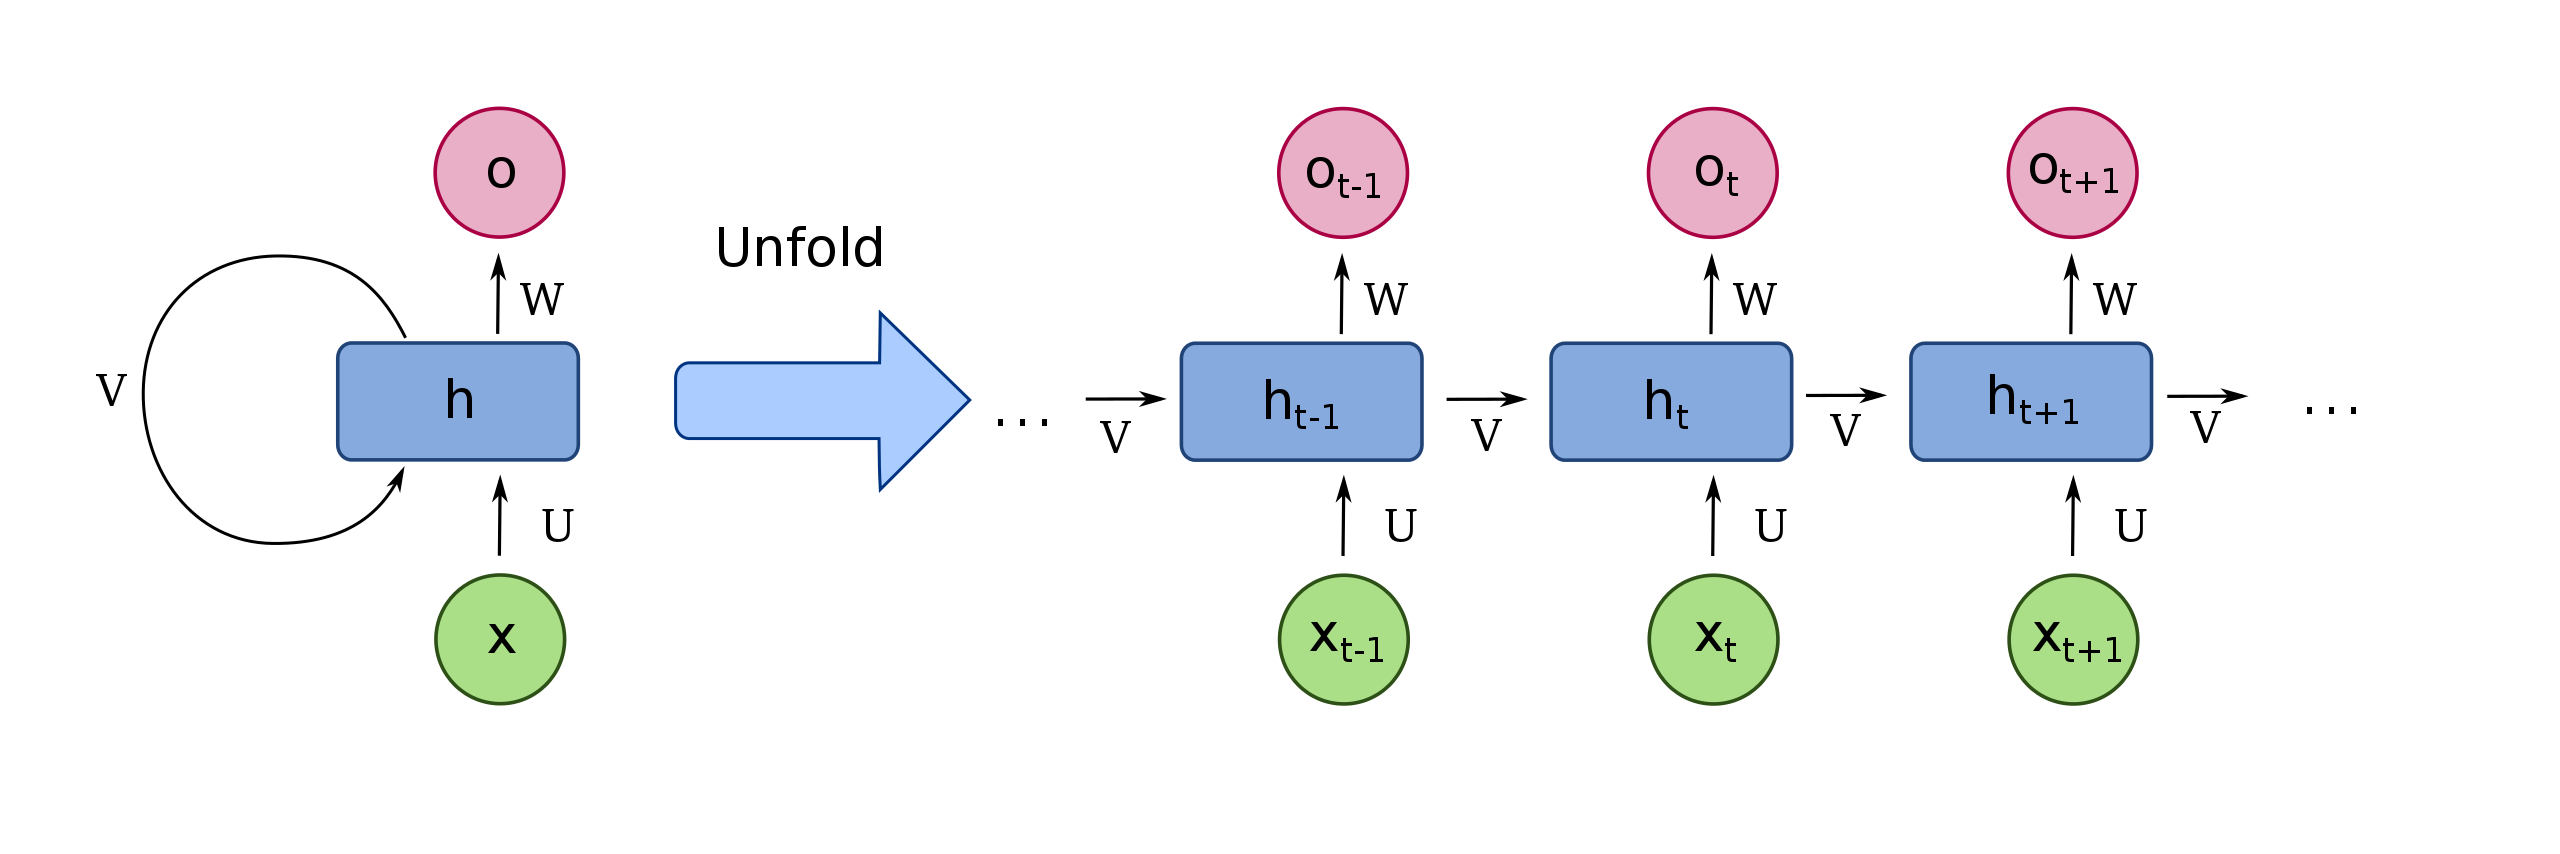

2. RNN의 과정

  - input : 우선 시퀀스 데이터(정보)는 벡터로 표현되어 model에 input

  - state : input인 벡터는 순서(Timestep)에 따라 순환신경망의 상태(파란색 상자)에 저장

  - update : W가 튜닝되면서 계속 Update

  - output : 매 Timestep마다 새로운 인풋이 들어오면서 다른 반응 결과를 출력

  - 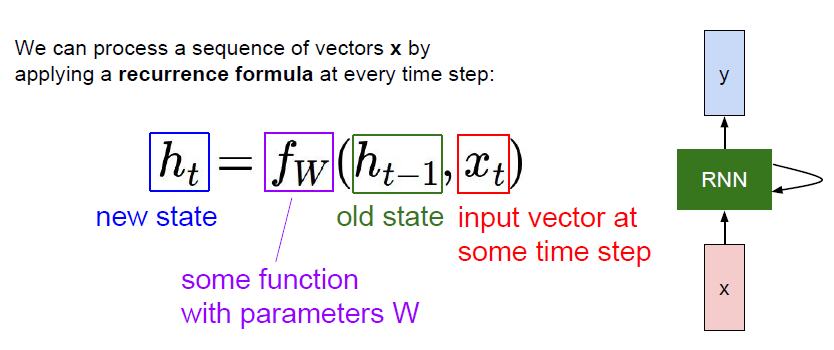

3. RNN의 한계

  - RNN은 출력과 먼 위치에 있는 정보를 기억할 수 없다. 

  - RNN은 입력정보와 출력지점 거리가 멀 경우 역전파 할 시 기울기가 0으로 수렴하던가 발산하여 학습능력이 저하된다.

  - Larget Singular Value > 1 (Exploding Gradients, 발산) ==> 기울기 클리핑

  - Larget Singular Value < 1 (Vanishing Gradients, 0으로 수렴) ==> LSTM Model

## LSTM (Long Short Term Memory)

1. LSTM 개념

   * LSTM : 불필요한 기억을 지우고, 기억해야할 것들을 정하여, 긴 시퀀스의 입력을 처리하는데 탁월한 성능을 보입니다.

   * RNN의 hidden state에 cell state(정보를 기억하는 역할)가 추가되어 구성

   * 3개의 게이트 구조 : 입력 게이트(input gate), 망각 게이트(forget gate), 출력 게이트(output gate)로 구성

   * 기존의 정보를 얼만큼 잊고 새로운 정보로 얼마나 대체할 것인



2. LSTM의 과정

  - forget : 과거의 정보를 잊기 위한 게이트

  - input : 우선 시퀀스 데이터(정보)는 벡터로 표현되어 model에 input

  - state : input인 벡터(가공된 정보)가 순서(Timestep)에 따라 이전 상태(old hiden state)와 함께 현재 상태(hiden State)에 저장되기 앞서 기억상태(cell state)가 참전하는 처리과정을 겪습니다. 이 처리과정에서는 3개의 gate(i, f, o)가 cell state의 참전(활성화)여부를 결정

  - update : W가 튜닝되면서 계속 Update (역전파 수식만 변경)

  - output : 매 Timestep마다 새로운 인풋이 들어오면서 다른 반응 결과를 출력

  - 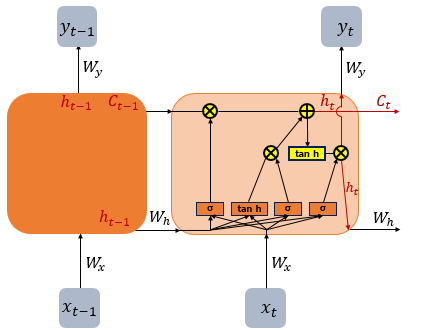

## Recurrent Neural Network Model

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd

# Pytorch 라이브러리
import torch
import torch.nn as nn # SGD, Adam 등과 같은 optimizer
import torch.optim as optim # 모든 neural network 모듈
import torch.nn.functional as F # Parameterless functions
from torch.utils.data import DataLoader # 미니배치를 생성하여 쉽게 데이터 셋 처리
import torchvision.datasets as datasets 
import torchvision.transforms as transforms # augumetation을 위해 데이터 세트에서 수행할 수 있는 변환
from tqdm import tqdm  # progress bar (진행상황 확인)

In [2]:
# 파이썬 코드를 재실행해도 같은 결과가 나오도록 랜덤 시드(random seed) 설정
torch.manual_seed(1)

In [3]:
# class torch.nn.RNN

# input_size – 입력해 주는 특성 값의 개수 입니다. 만약 feature의 개수가 1이라면 input_size=1, 입력 feature 개수가 7개면 input_size=7을 입력합니다.
# hidden_size – hidden state의 개수를 지정합니다. 보통 arbitrary 합니다.
# num_layers – RNN 레이어를 겹겹이 쌓아올릴 수 있습니다. RNN 레이어를 쌓아 올리는 것을 stacking RNN이라고도 합니다. 만약, 2개층을 겹겹이 쌓아올린다면 num_layers=2 로 설정하면 됩니다. 기본 값: 1
# batch_first – 입력으로 받는 데이터의 shape중 첫 번째 차원을 batch로 간주할 것인지를 설정합니다. 
#               일반적으로 pytorch에서 데이터 전처리시 batch를 첫번째 차원으로 지정하기 때문에 많은 케이스에서 batch_firtst=True 로 지정함을 볼 수 있습니다. 
#               True이면 입력 및 출력 텐서가 (seq, batch, feature) 대신 (batch, seq, feature)로 제공됩니다. 이는 hidden 또는 cell state에는 적용되지 않습니다. 기본값: False
# dropout – 0이 아닌 경우, 마지막 레이어를 제외한 각 RNN 레이어의 출력에 드롭아웃 레이어를 도입하며, 드롭아웃 확률은 dropout과 같습니다. 기본값: 0
# bidirectional – True로 설정된 경우, 양방향 RNN을 적용합니다. 기본 값: False
# sequence_length - RNN의 타임 스텝(윈도우) 크기

In [4]:
# Hyperparameters
input_size = 28
hidden_size = 256
num_layers = 2
num_classes = 10
sequence_length = 28
learning_rate = 0.005
batch_size = 64
num_epochs = 10

In [5]:
# Set device (Cuda / cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate RNN
        out, (hidden_state) = self.rnn(x, h0)

        # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

In [7]:
# Recurrent neural network with GRU (many-to-one)
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return 

In [8]:
# Recurrent neural network with LSTM (many-to-one)
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))  

        # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

In [21]:
# Create a bidirectional LSTM
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # bidirectional = True : 양방향 LSTM을 사용 (순방향, 역방향)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])

        return out

In [15]:
### MNIST dataset 
# input_size: the size of the input, in this case 784 (28x28)
# num_classes: the number of classes we want to predict, in this case 10 (0-9)
# Load Data
train_dataset = datasets.MNIST (root = "dataset/", train=True, transform = transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST (root = "dataset/", train=False, transform = transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
# model creating
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
model

RNN(
  (rnn): RNN(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7168, out_features=10, bias=True)
)

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

100%|██████████| 938/938 [00:08<00:00, 117.05it/s]


In [19]:
# Check accuracy on training & test 
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval() # eval mode에서 사용할 것이라고 모든 레이어에 선언하는 것

    # torch.no_grad() : 검증단계에서는 backprop을 하지 않을 것이기 때문에 
    # no_grad()로 감싸주고 이는 이 블럭 안에서는 그래디언트 트래킹을 안해도 된다 라고 선언 
    # ===> 메모리& 시간 감소
    with torch.no_grad():
        for x, y in loader:

            # Move data to device
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train() # eval => train 
    return num_correct / num_samples

In [20]:
# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set : {check_accuracy(train_loader, model)*100:2f}")
print(f"Accuracy on test set : {check_accuracy(test_loader, model)*100:2f}")

Accuracy on training set : 84.483330
Accuracy on test set : 84.970001
